In [616]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# **Data collection and manipulation**
### We used 'co2_mm_mlo.csv', 'graph.csv', and 'N_seaice_extent_daily_v3.0.csv' and ran some mathematical computations on that to obtain our final dataset that would be 'sea_avg_multi.csv' used throughout this coursework (we only need to read sea_avg_multi.csv and the original CSVs are being uploaded as well to show that they are original and unedited. They are used for preprocessing only)

In [617]:
class Preprocess():
    def __init__(self):
        sea_ice_data = pd.read_csv('N_seaice_extent_daily_v3.0.csv')
        sea_ice_data = sea_ice_data.drop(index = 0, axis = 0)
        sea_ice_data = sea_ice_data.rename(columns = lambda x: x.strip())
        sea_ice_data = sea_ice_data.drop(columns = ['Month', 'Day', 'Missing', 'Source Data'], axis = 1)
        sea_ice_data = self.sea_ice_averages(sea_ice_data)

        co2_data = pd.read_csv('co2_mm_mlo.csv')
        co2_data = co2_data.rename(columns = lambda x: x.strip())
        co2_data = co2_data.drop(columns = ['month', 'decimal date', 'de-seasonalized', '#days', 'st.dev of days', 'unc. of mon mean'], axis = 1)
        co2_data = self.co2_averages(co2_data)
        co2_data = co2_data.loc[co2_data['year'] > 1977]
        co2_data = co2_data.reset_index()

        celsius_data = pd.read_csv('graph.csv')
        celsius_data = celsius_data.rename(columns = lambda x: x.strip())
        celsius_data = celsius_data.drop(columns = ['Lowess(5)'], axis = 1)
        celsius_data = celsius_data.loc[celsius_data['Year'] > 1977]
        celsius_data = celsius_data.append(pd.DataFrame({'Year': [2022],
                                          'No_Smoothing': [0.84] #interpolated as 2021 value, assuming the data follows a trend
                                         }))
        celsius_data = celsius_data.reset_index()                             

        all_data = sea_ice_data
        all_data['Global CO2'] = co2_data['monthly average']
        all_data['Temp Diff From Average'] = celsius_data['No_Smoothing']
        
        sea_ice_data.to_csv('sea_avg_multi.csv', index=False) #The other three csv files are used and manipualted so we can obtain a final csv having average value of features over the years
    
    def sea_ice_averages(self, sea_ice_data):
        sea_ice_data['Year'] = pd.to_numeric(sea_ice_data['Year'])
        sea_ice_data['Extent'] = pd.to_numeric(sea_ice_data['Extent'])
        
        unique_vals = pd.unique(sea_ice_data['Year'])

        yearly_averages = []
        for i in unique_vals:
            x = 0
            y = 0
            for index, row in sea_ice_data.iterrows():
                if row['Year'] == i:
                    x += row['Extent']
                    y += 1
                    sea_ice_data = sea_ice_data.drop(index, axis = 0)
                else:
                    break
            yearly_averages.append(x / y)

        sea_ice_data['Year'] = unique_vals
        sea_ice_data['Extent'] = yearly_averages
        sea_ice_data.to_csv('sea_avg.csv', index=False) #SEA ICE DATA TO A CSV
        return sea_ice_data

    def co2_averages(self, co2_data):
        co2_data['year'] = pd.to_numeric(co2_data['year'])
        co2_data['monthly average'] = pd.to_numeric(co2_data['monthly average'])
        
        unique_vals = pd.unique(co2_data['year'])

        yearly_averages = []
        for i in unique_vals:
            x = 0
            y = 0
            for index, row in co2_data.iterrows():
                if row['year'] == i:
                    x += row['monthly average']
                    y += 1
                    co2_data = co2_data.drop(index, axis = 0)
                else:
                    break
            yearly_averages.append(x / y)

        co2_data['year'] = unique_vals
        co2_data['monthly average'] = yearly_averages
        return co2_data

def main():
    df = Preprocess()
if __name__ == '__main__':
    main()

C:\Users\goyal\AppData\Local\Temp\ipykernel_93712\427429029.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  celsius_data = celsius_data.append(pd.DataFrame({'Year': [2022],


***

## Reading CSV file and splitting it into Train and Test

In [1256]:
df = pd.read_csv('sea_avg_multi.csv')
print(df.head())

df = df.sample(frac=1, random_state=20).reset_index(drop=True) #shuffle dataframe

#Splitting in train and test
split = math.floor(df.shape[0]*0.2) #80-20% split
test = df.head(n=split)
train = df.drop(index=df.index[:split]).reset_index(drop=True)

print(train.shape)
print(test.shape)

   Year     Extent  Global CO2  Temp Diff From Average
0  1978  12.487000  335.415000                    0.07
1  1979  12.319560  336.835000                    0.16
2  1980  12.334148  338.762500                    0.26
3  1981  12.135486  340.120000                    0.32
4  1982  12.439445  341.478333                    0.14
(36, 4)
(9, 4)


## Splitting our data into X(features) and y(outcome)

In [1257]:
#Splitting X and Y
y_train = train['Extent'].to_numpy()
y_test = test['Extent'].to_numpy()

X_train = train.drop(['Extent'],axis=1)
X_test = test.drop(['Extent'],axis=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36, 3) (9, 3) (36,) (9,)


## Boxplot before normalisation to identify outliers and verify the need of normalisation

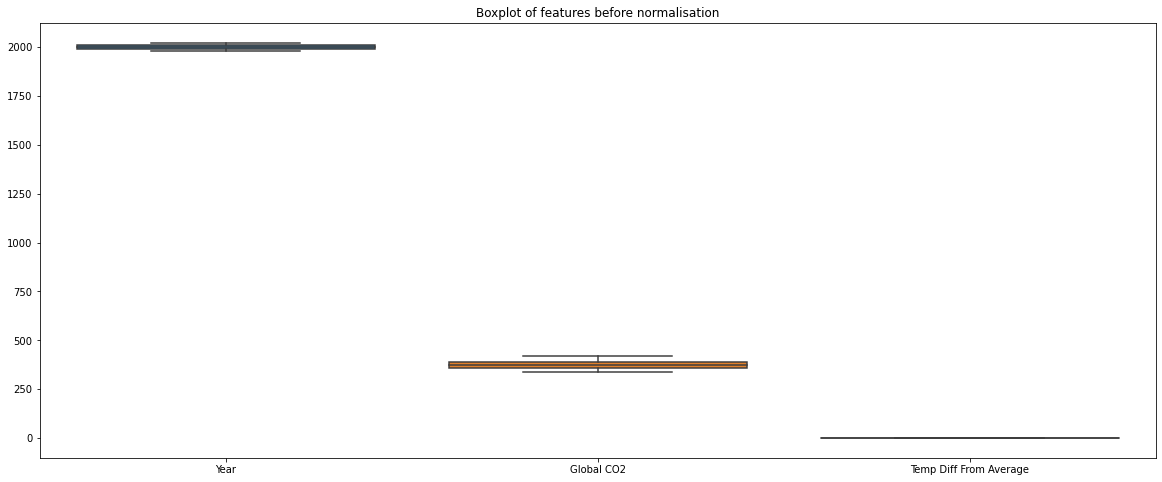

In [1258]:
#Boxplot before normalisation
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=X_train.iloc[:, :],ax=ax)
plt.title('Boxplot of features before normalisation')
plt.show()

#### We can clearly tell this data needs to be normalised as the features are in very different range

## Z normalisation

In [1259]:
#Z normalisation
mu = np.mean(X_train,axis=0)
sigma = np.std(X_train,axis=0)
print(mu.shape, sigma.shape)

X_train_norm = (X_train-mu)/sigma
X_train_norm.head()

(3,) (3,)


,Year,Global CO2,Temp Diff From Average
0,-0.762153,-0.794758,-1.316136
1,-0.514969,-0.603035,-0.408930
2,0.061796,-0.061825,0.333329
3,1.544906,1.706310,1.982794
4,-1.668498,-1.506846,-0.903769


### Boxplot of features after normalisation proving they are in the same range now

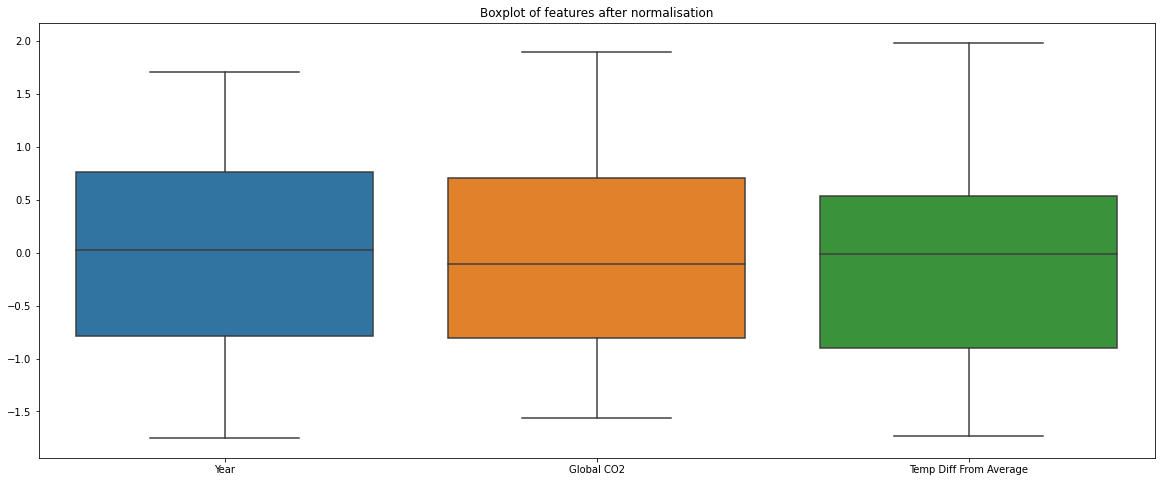

In [1260]:
#Boxplot after normalisation
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=X_train_norm.iloc[:, :],ax=ax)
plt.title('Boxplot of features after normalisation')
plt.show()

## Adding a column of 1s to our feature matrix so we can apply dot product for weights and features

In [1261]:
#Adding column of 1 in X to multiply with beta0
X_zero = np.ones((X_train_norm.shape[0],1))
X_train_norm = np.hstack((X_zero,X_train_norm))
print(X_train_norm.shape)

(36, 4)


## Plotting individual features against ice extent(output) to identify any linear relation amongst them

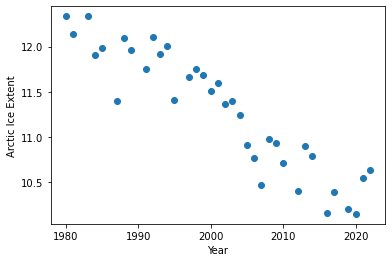

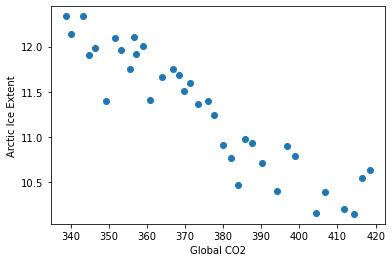

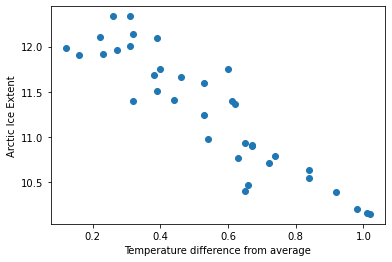

In [1262]:
#Plots of individual features against ice extent to see if there is a linear regression amongst the features and output variable
plt.scatter(X_train['Year'],y_train)
plt.xlabel('Year')
plt.ylabel('Arctic Ice Extent')
plt.show()
plt.scatter(X_train['Global CO2'],y_train)
plt.xlabel('Global CO2')
plt.ylabel('Arctic Ice Extent')
plt.show()
plt.scatter(X_train['Temp Diff From Average'],y_train)
plt.xlabel('Temperature difference from average')
plt.ylabel('Arctic Ice Extent')
plt.show()

#### Features show a linear relation against the output variable ice extent so we will proceed with linear regression expecting good results

## Correlation between features

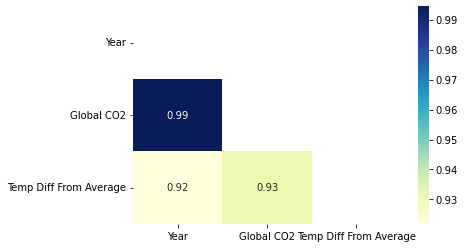

In [1263]:
#correlation between features
mask = np.triu(np.ones_like(X_train.corr()))
dataplot = sns.heatmap(X_train.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

<br>

# Building Linear Regression for multiple features

In [1264]:
class multiLinearRegression:
    def __init__(self):
        print("Regressor created")
        
    def predict(self, X,beta):
        return np.dot(X,beta)

    def error(self, X,y,beta):
        m = X.shape[0]
        e = 0.0
        y_hat = self.predict(X,beta)
        e = (np.sum((y-y_hat)**2))/m
        
        return e

    def r2_score(self, X,y):
        y_hat = self.predict(X,beta)
        num = np.sum((y-y_hat)**2)
        denom = np.sum((y-y.mean())**2)
        score = (1-num/denom)
        
        return score*100

    def gradient(self, X,y,beta):
        m = X.shape[0]
        y_hat = self.predict(X,beta)
        grad = (np.dot(X.T,(y_hat-y)))/m
        
        return grad

    def fit(self, X,y,learning_rate=0.05,max_epochs=100):
        n = X.shape[1]
        beta = np.zeros((n,))
        error_list = []

        for i in range(max_epochs):
            e = self.error(X,y,beta)
            error_list.append(e)

            grad = self.gradient(X,y,beta)
            beta = beta - learning_rate*grad

        return beta,error_list

    def test_preprocess(self, X):
        X = (X-mu)/sigma
        X_zero = np.ones((X.shape[0],1))
        X = np.hstack((X_zero,X))
    
        return X

## Fitting in the model

In [1265]:
learning_rate = 0.1
epochs = 500
model = multiLinearRegression()
beta, error_list = model.fit(X_train_norm,y_train,learning_rate,epochs)

Regressor created


### Printing the learnable weights we got after training of our model

In [1266]:
print("Value of weights are: ",beta)

Value of weights are:  [11.29327245 -0.20826991 -0.17998155 -0.24349033]


### Plotting error(MSE) curve

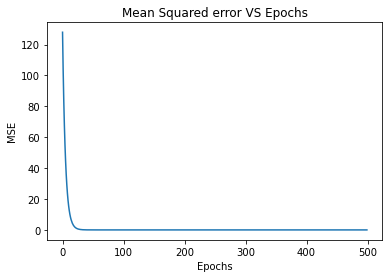

In [1267]:
#Plotting error
plt.plot(error_list)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared error VS Epochs')
plt.show()

## Running evaluation on test(unseen) set

In [1268]:
#Evaluation on test set
print("MSE on train set: ",model.error(X_train_norm,y_train,beta))
print("R^2 score on train set: ",model.r2_score(X_train_norm,y_train))

X_test = model.test_preprocess(X_test)
print("MSE on test set: ",model.error(X_test,y_test,beta))
print("R^2 score on test set: ",model.r2_score(X_test,y_test))

MSE on train set:  0.052819448808772144
R^2 score on train set:  87.92941968809271
MSE on test set:  0.028605078869859486
R^2 score on test set:  95.9213030863581


## Making predictions using our model

In [1269]:
data = [[1978, 335.415000,0.07],[1979,336.835000,0.16]]
test_df = pd.DataFrame(data, columns=['Year', 'Global CO2', 'Temp Diff From Average'])
test_df = model.test_preprocess(test_df)
pred = model.predict(test_df,beta)
print("Predictions are: ",pred)

Predictions are:  [12.47124403 12.35263759]


<br><br><br>

***

# **Predicting the year when ice extent is going to hit zero**

## Splitting data into train and test

In [1270]:
data = df.drop(['Global CO2', 'Temp Diff From Average'],axis=1)
print(data.head())

data = data.sample(frac=1, random_state=10).reset_index(drop=True) #shuffle dataframe

#Splitting in train and test
split = math.floor(data.shape[0]*0.2) #80-20% split
test = data.head(n=split)
train = data.drop(index=df.index[:split]).reset_index(drop=True)
print(train.shape)
print(test.shape)

   Year     Extent
0  1986  12.208224
1  1982  12.439445
2  1979  12.319560
3  2015  10.565816
4  2011  10.483496
(36, 2)
(9, 2)


## Splitting data into X(features) and y(outcome)

In [1271]:
#Splitting X and Y
y_train = train['Extent'].to_numpy()
y_test = test['Extent'].to_numpy()

X_train = train.drop(['Extent'],axis=1)
X_ = X_train.copy()
X_test = test.drop(['Extent'],axis=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36, 1) (9, 1) (36,) (9,)


## Z normalisation

In [1272]:
#Z normalisation
mu = np.mean(X_train,axis=0)
sigma = np.std(X_train,axis=0)
print(mu.shape, sigma.shape)

X_train = (X_train-mu)/sigma
X_train.head()

(1,) (1,)


,Year
0,1.583213
1,-0.636368
2,-1.508346
3,-0.002202
4,1.821025


## Adding a column of 1s to our feature matrix so we can apply dot product for weights and features

In [1273]:
#Adding column of 1 in X to multiply with beta0
X_zero = np.ones((X_train.shape[0],1))
X_train = np.hstack((X_zero,X_train))
print(X_train.shape)

(36, 2)


<br>

# Building Univariate Linear Regression as we have year as only input

In [1274]:
class linearRegression:
    def __init__(self):
        print("Regressor created")
        
    def predict(self, X,beta):
        return np.dot(X,beta)

    def error(self, X,y,beta):
        m = X.shape[0]
        e = 0.0
        y_hat = self.predict(X,beta)
        e = (np.sum((y-y_hat)**2))/m
        
        return e

    def r2_score(self, X,y):
        y_hat = self.predict(X,beta)
        num = np.sum((y-y_hat)**2)
        denom = np.sum((y-y.mean())**2)
        score = (1-num/denom)
        
        return score*100

    def gradient(self, X,y,beta):
        m = X.shape[0]
        y_hat = self.predict(X,beta)
        grad = (np.dot(X.T,(y_hat-y)))/m
        
        return grad

    def fit(self, X,y,learning_rate=0.05,max_epochs=100):
        n = X.shape[1]
        beta = np.zeros((n,))
        error_list = []

        for i in range(max_epochs):
            e = self.error(X,y,beta)
            error_list.append(e)

            grad = self.gradient(X,y,beta)
            beta = beta - learning_rate*grad

        return beta,error_list

    def test_preprocess(self, X):
        X = (X-mu)/sigma
        X_zero = np.ones((X.shape[0],1))
        X = np.hstack((X_zero,X))
        
        return X

## Fitting in the model

In [1275]:
learning_rate = 0.1
epochs = 200
model = linearRegression()
beta, error_list = model.fit(X_train,y_train,learning_rate,epochs)

Regressor created


### Printing the learnable weights we got after training of our model

In [1276]:
print("Learned weights are: ",beta)

Learned weights are:  [11.47510523 -0.64902219]


### Plotting error(MSE) curve

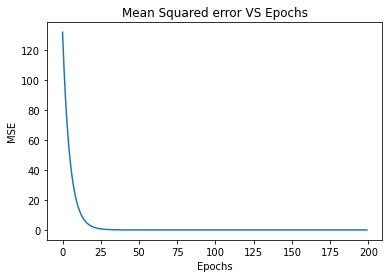

In [1277]:
#Plotting error
plt.plot(error_list)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared error VS Epochs')
plt.show()

## Running evaluation on train and test(unseen) set

In [1278]:
#Evaluation on train set
print("MSE on train set: ",model.error(X_train,y_train,beta))
print("R^2 score on train set: ",model.r2_score(X_train,y_train))

#Evaluation on train set
X_test = model.test_preprocess(X_test)
print("MSE on test set: ",model.error(X_test,y_test,beta))
print("R^2 score on test: ",model.r2_score(X_test,y_test))

MSE on train set:  0.055661286297998
R^2 score on train set:  88.32830222364335
MSE on test set:  0.061522979097221105
R^2 score on test:  81.23969011507145


### Plotting the line fitted by our model against the input data

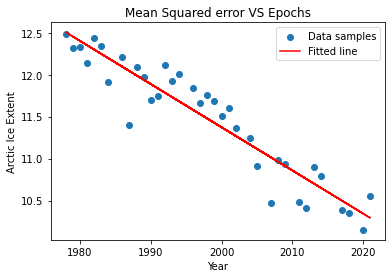

In [1279]:
#plotting fitted line
y_hat = predict(X_train,beta)
plt.scatter(X_['Year'],y_train, label='Data samples')
plt.plot(X_['Year'],y_hat, color='red', label = 'Fitted line')
plt.xlabel('Year')
plt.ylabel('Arctic Ice Extent')
plt.title('Mean Squared error VS Epochs')
plt.legend()
plt.show()

## Extrapolating our linear regression line to predict the year that ice extent would hit zero

Year when ice extent hits 0 is:  2221


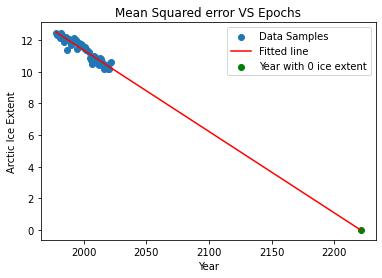

In [1280]:
#Takes numpy array as input instead of dataframe like in the method built in class
def prediction(X_test):
    df_test = pd.DataFrame(X_test, columns=['Year'])
    df_test = (df_test-mu)/sigma
    X_zero = np.ones((df_test.shape[0],1))
    X_test = np.hstack((X_zero,df_test))
    y_pred = predict(X_test,beta)
    return y_pred


#Predicting in which year ice extent would hit zero

y_pred = []
year = []
yr = 1978
while(True):
    y_hat = prediction(np.array([yr]))
    if(y_hat<0):
        break
    year.append(yr)
    y_pred.append(y_hat)
    yr = yr+1
    
print("Year when ice extent hits 0 is: ",year[-1])
plt.scatter(df['Year'],df['Extent'], label = 'Data Samples')
plt.plot(year,y_pred, color='red', label = 'Fitted line')
plt.scatter(year[-1],y_pred[-1],color='green',label = 'Year with 0 ice extent')
plt.xlabel('Year')
plt.ylabel('Arctic Ice Extent')
plt.title('Mean Squared error VS Epochs')
plt.legend()
plt.show()

### So by extrapolating our linearly fitted line, we can tell that the ice extent is predicted to hit zero in the year "2221"

<br><br><br>

***

# **Polynomial Regression**

## Reading CSV file and splitting it into Train and Test

In [1281]:
df = pd.read_csv('sea_avg_multi.csv')
print(df.head())

df = df.sample(frac=1, random_state=20).reset_index(drop=True) #shuffle dataframe

#Splitting in train and test
split = math.floor(df.shape[0]*0.2) #80-20% split
test = df.head(n=split)
train = df.drop(index=df.index[:split]).reset_index(drop=True)
print(train.shape)
print(test.shape)

   Year     Extent  Global CO2  Temp Diff From Average
0  1978  12.487000  335.415000                    0.07
1  1979  12.319560  336.835000                    0.16
2  1980  12.334148  338.762500                    0.26
3  1981  12.135486  340.120000                    0.32
4  1982  12.439445  341.478333                    0.14
(36, 4)
(9, 4)


## Splitting our data into X(features) and y(outcome)

In [1282]:
#Splitting X and Y
y_train = train['Extent'].to_numpy()
y_test = test['Extent'].to_numpy()

X_train = train.drop(['Extent'],axis=1)
X_test = test.drop(['Extent'],axis=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36, 3) (9, 3) (36,) (9,)


## Creating polynomial features

In [1283]:
degree = 3
col_list = X_train.columns

for i in range(2,degree+1):
    for col in col_list:
        new_degree = str(i)
        col_degree = col+'^'+new_degree
        X_train[col_degree] = X_train[col]**i

X_train.head()

,Year,Global CO2,Temp Diff From Average,Year^2,Global CO2^2,Temp Diff From Average^2,Year^3,Global CO2^3,Temp Diff From Average^3
0,1992,356.545833,0.22,3968064,127124.931267,0.0484,7904383488,4.532586e+07,0.010648
1,1995,360.968333,0.44,3980025,130298.137669,0.1936,7940149875,4.703350e+07,0.085184
2,2002,373.452500,0.62,4008004,139466.769756,0.3844,8024024008,5.208421e+07,0.238328
3,2020,414.238333,1.02,4080400,171593.396803,1.0404,8242408000,7.108056e+07,1.061208
4,1981,340.120000,0.32,3924361,115681.614400,0.1024,7774159141,3.934563e+07,0.032768


## Z normalisation

In [1284]:
#Z normalisation
mu = np.mean(X_train,axis=0)
sigma = np.std(X_train,axis=0)
print(mu.shape, sigma.shape)

X_train = (X_train-mu)/sigma
X_train.head()

(9,) (9,)


,Year,Global CO2,Temp Diff From Average,Year^2,Global CO2^2,Temp Diff From Average^2,Year^3,Global CO2^3,Temp Diff From Average^3
0,-0.762153,-0.794758,-1.316136,-0.763455,-0.798783,-1.056393,-0.764737,-0.801014,-0.840268
1,-0.514969,-0.603035,-0.408930,-0.517217,-0.616968,-0.546981,-0.519451,-0.629158,-0.584861
2,0.061796,-0.061825,0.333329,0.058778,-0.091635,0.122412,0.055758,-0.120855,-0.060095
3,1.544906,1.706310,1.982794,1.549173,1.749116,2.423889,1.553436,1.790935,2.759604
4,-1.668498,-1.506846,-0.903769,-1.663156,-1.454448,-0.866942,-1.657817,-1.402864,-0.764471


## Adding a column of 1s to our feature matrix so we can apply dot product for weights and features

In [1285]:
#Adding column of 1 in X to multiply with beta0
X_zero = np.ones((X_train.shape[0],1))
X_train = np.hstack((X_zero,X_train))
print(X_train.shape)

(36, 10)


<br>

# Building Polynomial Linear Regression

In [1286]:
class polyLinearRegression:
    def __init__(self):
        print("Regressor created")
        
    def predict(self, X,beta):
        return np.dot(X,beta)

    def error(self, X,y,beta):
        m = X.shape[0]
        e = 0.0
        y_hat = self.predict(X,beta)
        e = (np.sum((y-y_hat)**2))/m
        
        return e

    def r2_score(self, X,y):
        y_hat = self.predict(X,beta)
        num = np.sum((y-y_hat)**2)
        denom = np.sum((y-y.mean())**2)
        score = (1-num/denom)
        
        return score*100

    def gradient(self, X,y,beta):
        m = X.shape[0]
        y_hat = self.predict(X,beta)
        grad = (np.dot(X.T,(y_hat-y)))/m
        
        return grad

    def fit(self, X,y,learning_rate=0.05,max_epochs=100):
        n = X.shape[1]
        beta = np.zeros((n,))
        error_list = []

        for i in range(max_epochs):
            e = self.error(X,y,beta)
            error_list.append(e)

            grad = self.gradient(X,y,beta)
            beta = beta - learning_rate*grad

        return beta,error_list

    def test_preprocess(self, X,degree):
        col_list = X.columns

        for i in range(2,degree+1):
            for col in col_list:
                new_degree = str(i)
                col_degree = col+'^'+new_degree
                X[col_degree] = X[col]**i
        
        X = (X-mu)/sigma
        X_zero = np.ones((X.shape[0],1))
        X = np.hstack((X_zero,X))
        
        return X

## Fitting in the model

In [1287]:
learning_rate = 0.1
epochs = 200
model = polyLinearRegression()
beta, error_list = model.fit(X_train,y_train,learning_rate,epochs)

Regressor created


### Printing the learnable weights we got after training of our model

In [1288]:
print("Learned weights are: ",beta)

Learned weights are:  [ 1.12932724e+01 -1.06020550e-01 -5.39877480e-02 -1.22446717e-01
 -1.04282625e-01 -2.67670202e-02 -9.01372514e-02 -1.02526803e-01
  2.19955998e-03 -3.27245298e-02]


### Plotting error(MSE) curve

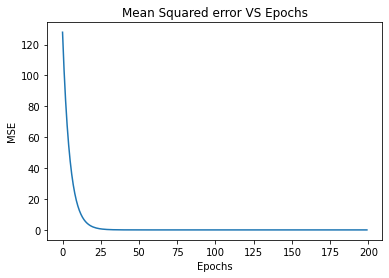

In [1289]:
#Plotting error
plt.plot(error_list)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared error VS Epochs')
plt.show()

## Running evaluation on train and test(unseen) set

In [1290]:
#Evaluation on train set
print("MSE on train set: ",model.error(X_train,y_train,beta))
print("R^2 score on train set: ",model.r2_score(X_train,y_train))

#Evaluation on train set
degree=3
X_test = model.test_preprocess(X_test,degree)
print("MSE on test set: ",model.error(X_test,y_test,beta))
print("R^2 score on test set: ",model.r2_score(X_test,y_test))

MSE on train set:  0.051887629023034454
R^2 score on train set:  88.14236408288735
MSE on test set:  0.03574176984598722
R^2 score on test set:  94.90370758905571


## Making predictions using our model

In [1291]:
data = [[1978, 335.415000,0.07],[1979,336.835000,0.16]]
test_df = pd.DataFrame(data, columns=['Year', 'Global CO2', 'Temp Diff From Average'])
degree=3
test_df = model.test_preprocess(test_df,degree)
pred = model.predict(test_df,beta)
print("Predictions are: ",pred)

Predictions are:  [12.39732948 12.31475036]


<br><br><br>

***

# **Artificial Neural Network**

## Reading CSV file and splitting it into Train and Test

In [1292]:
df = pd.read_csv('sea_avg_multi.csv')
print(df.head())

df = df.sample(frac=1, random_state=20).reset_index(drop=True) #shuffle dataframe

#Splitting in train and test
split = math.floor(df.shape[0]*0.2) #80-20% split
test = df.head(n=split)
train = df.drop(index=df.index[:split]).reset_index(drop=True)
print(train.shape)
print(test.shape)

   Year     Extent  Global CO2  Temp Diff From Average
0  1978  12.487000  335.415000                    0.07
1  1979  12.319560  336.835000                    0.16
2  1980  12.334148  338.762500                    0.26
3  1981  12.135486  340.120000                    0.32
4  1982  12.439445  341.478333                    0.14
(36, 4)
(9, 4)


## Splitting data into X(features) and y(outcome)

In [1293]:
#Splitting X and Y
y_train = train['Extent'].to_numpy()
y_train = np.reshape(y_train, ((y_train.shape[0], 1)))

y_test = test['Extent'].to_numpy()
y_test = np.reshape(y_test, ((y_test.shape[0], 1)))

X_train = train.drop(['Extent'],axis=1)
X_train = X_train.to_numpy()

X_test = test.drop(['Extent'],axis=1)
X_test = X_test.to_numpy()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36, 3) (9, 3) (36, 1) (9, 1)


## Z normalisation

In [1294]:
#Z normalisation
mu = np.mean(X_train,axis=0)
sigma = np.std(X_train,axis=0)
print(mu.shape, sigma.shape)

X_train = (X_train-mu)/sigma

(3,) (3,)


<br>

# Building Artificial Neural Network

In [1295]:
class NeuralNetwork:
    def __init__(self,input_size,l,output_size, activationfunction="tanh"):
        np.random.seed(0)
        model = {}
        #for hidden layer
        model['W1']  = np.random.randn(input_size,l[0])
        model['b1'] = np.random.randn(1,l[0])
        
        #for output layer
        model['W2']  = np.random.randn(l[0],output_size)
        model['b2'] = np.random.randn(1,output_size)
        
        self.model = model
        self.activationfunction = activationfunction

    def linear(self, a):
      return a

    def relu(self, a):
      return(np.maximum(0, a))

    def reluderivative(self, a) :
      temp=a.copy()
      for i in range(a.shape[0]):
        for j in range(a.shape[1]):
          if(temp[i][j]>0):
            temp[i][j] = 1
          else:
            temp[i][j] = 0
      return temp
            
    def forward(self,x):
        W1,W2 = self.model['W1'],self.model['W2']
        b1,b2 = self.model['b1'],self.model['b2']
        
        #hidden layer
        z1 = np.dot(x,W1) + b1
        if(self.activationfunction=="relu"):
          a1 = self.relu(z1)
        if(self.activationfunction=="tanh"):
          a1 = np.tanh(z1)

        #output layer
        z2 = np.dot(a1,W2) + b2
        y_ = self.linear(z2)
        
        # Store the layer wise output for backprop later
        self.activations = (a1,y_)
        self.z = (z1, z2)
        return y_
    
    def backward(self,x,y,learning_rate=0.01):
        W1,W2 = self.model['W1'],self.model['W2']
        b1,b2 = self.model['b1'],self.model['b2']
        a1,y_ = self.activations
        z1, z2 = self.z

        # Output layer
        d2 = (y_ - y)
        dw2 = np.dot(a1.T,d2)
        db2 = np.sum(d2,axis=0)
        
        # Hidden layer
        d1 = np.dot(d2,W2.T)
        if(self.activationfunction=="relu"):
          d1 = d1*(self.reluderivative(z1))
        if(self.activationfunction=="tanh"):
          d1 = d1 * (1-np.square(a1))
        dw1 = np.dot(x.T,d1)
        db1 = np.sum(d1,axis=0)
        
        # Gradient Descent 
        self.model['W1'] -= learning_rate*dw1
        self.model['W2'] -= learning_rate*dw2
        self.model['b1'] -= learning_rate*db1
        self.model['b2'] -= learning_rate*db2
    
    def predict(self,x):
        out = self.forward(x)
        return out

    def loss(self, y,y_):
      l = (1/2)*np.mean((y_-y)**2)
      return l

    def r2Score(self,y, y_):
      num = np.sum((y-y_)**2)
      denom = np.sum((y-y.mean())**2)
      score = (1-num/denom)
      return score*100

    def fit(self, X ,Y,epochs, learning_rate):
    
      train_loss = []
      
      for i in range(epochs):
          Y_ = self.forward(X)
          l = self.loss(Y,Y_)
          train_loss.append(l)
          model.backward(X,Y, learning_rate)
          if ((i+1)%1000==0):
              r2score = self.r2Score(Y,Y_)
              print("Epoch %d Loss %.2f R2_score %.2f"%(i+1,l,r2score))
      return train_loss

    def test_preprocess(self, X):
        test_df = (X-mu)/sigma
        return test_df

## Fitting in the model

In [1296]:
# Model Details
input_size = 3
layers = [2] #Hidden Layers
output_size = 1
model = NeuralNetwork(input_size,layers,output_size, activationfunction="relu")
error_list = model.fit(X_train, y_train, epochs=25000, learning_rate=0.003)

#0.003 - relu
#0.02 - tanh

Epoch 1000 Loss 0.02 R2_score 90.01
Epoch 2000 Loss 0.02 R2_score 90.11
Epoch 3000 Loss 0.02 R2_score 90.19
Epoch 4000 Loss 0.02 R2_score 90.28
Epoch 5000 Loss 0.02 R2_score 90.38
Epoch 6000 Loss 0.02 R2_score 90.49
Epoch 7000 Loss 0.02 R2_score 90.61
Epoch 8000 Loss 0.02 R2_score 90.74
Epoch 9000 Loss 0.02 R2_score 90.85
Epoch 10000 Loss 0.02 R2_score 90.92
Epoch 11000 Loss 0.02 R2_score 90.99
Epoch 12000 Loss 0.02 R2_score 91.04
Epoch 13000 Loss 0.02 R2_score 91.04
Epoch 14000 Loss 0.02 R2_score 91.03
Epoch 15000 Loss 0.02 R2_score 90.99
Epoch 16000 Loss 0.02 R2_score 91.15
Epoch 17000 Loss 0.02 R2_score 91.12
Epoch 18000 Loss 0.02 R2_score 91.08
Epoch 19000 Loss 0.02 R2_score 91.07
Epoch 20000 Loss 0.02 R2_score 91.08
Epoch 21000 Loss 0.02 R2_score 91.75
Epoch 22000 Loss 0.02 R2_score 91.81
Epoch 23000 Loss 0.02 R2_score 91.83
Epoch 24000 Loss 0.02 R2_score 91.84
Epoch 25000 Loss 0.02 R2_score 91.85


### Plotting error(MSE) curve

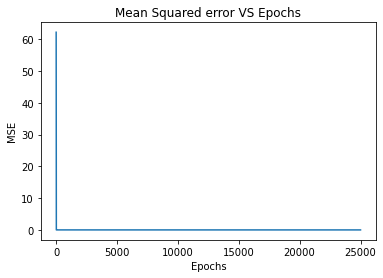

In [1297]:
plt.plot(error_list)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Mean Squared error VS Epochs')
plt.show()

## Running evaluation on train and test(unseen) set

In [1298]:
#Evaluation on train set
y_hat = model.predict(X_train)
print("MSE on train set: ",model.loss(y_train,y_hat))
print("R^2 score on train set: ",model.r2Score(y_train,y_hat))

#Evaluation on train set
X_test = model.test_preprocess(X_test)
y_hat = model.predict(X_test)
print("MSE on test set: ",model.loss(y_test,y_hat))
print("R^2 score on test set: ",model.r2Score(y_test,y_hat))

MSE on train set:  0.017829526660332492
R^2 score on train set:  91.85100419142982
MSE on test set:  0.019691822331523764
R^2 score on test set:  94.38442555372927


In [1299]:
data = [[1978, 335.415000,0.07],[1979,336.835000,0.16]]
data = np.array(data)
test_df = model.test_preprocess(data)
pred = model.predict(test_df)
print("Predictions are: ",pred)

Predictions are:  [[12.3133112 ]
 [12.28884847]]


***

## Inference: By comparing our evaluation measures used for regression which contains MSE and R^2 score, we choose Linear Regression as our optimal model for this coursework and save the learned weights(beta) to make further predictions of "arctic ice extent" on unseen data. Linear regression being the simplest model in architecture compared to other models we used (polynomial regression and ANN) also is one of the factor for picking linear regression as it saves us some computation power.

***

# References
- NumPy (no date). Available at: https://numpy.org/ (Accessed: 23 December 2023).
- pandas - Python Data Analysis Library (no date). Available at: https://pandas.pydata.org/ (Accessed: 23 December 2023).
- Matplotlib — Visualization with Python (no date). Available at: https://matplotlib.org/ (Accessed: 23 December 2023).
- seaborn: statistical data visualization — seaborn 0.12.2 documentation (no date). Available at: https://seaborn.pydata.org/ (Accessed: 01 January 2023).
- Coding Blocks | Master Machine learning using Python (no date). Available at: https://codingblocks.com/machine-learning-using-python.html#syllabustabcontent6 (Accessed: 24 January 2023).
- machine-learning-aug-2019/Neural_Network.ipynb at master · coding-blocks-archives/machine-learning-aug-2019 (no date). Available at: https://github.com/coding-blocks-archives/machine-learning-aug-2019/blob/master/Neural%20Network%20-%2012%20Oct/Neural_Network.ipynb (Accessed: 24 January 2023).